# This is a copy for self-learning for [Computing polygenic scores using LDpred2](https://privefl.github.io/bigsnpr/articles/LDpred2.html#downloading-genotype-data-and-summary-statistics-1)

Note that most of the algorithms of this package don’t handle **missing values**. You can use snp_fastImpute() (taking a few hours for a chip of 15K x 300K) and snp_fastImputeSimple() (taking a few minutes only) to impute missing values of genotyped variants.

## Downloading genotype data and summary statistics
You can download data and unzip files in R. We store those files in a directory called "tmp-data" here.

You can see there how we generated these data from the 1000 Genomes project. Note that these data are for educational purposes only, not for use as a reference panel.

First, you need to read genotype data from the PLINK files (or BGEN files) as well as the text file containing summary statistics.

In [1]:
library(bigsnpr)

Loading required package: bigstatsr



+ Self-dir

In [2]:
path <- "C:\\data\\tmp-data\\"

In [3]:
snp_readBed("C:\\data\\tmp-data\\public-data.bed")

ERROR: Error: File 'C:\data\tmp-data\public-data.bk' already exists.


In [4]:
obj.bigSNP <- snp_attach("C:\\data\\tmp-data\\public-data.rds")
# See how the file looks like
str(obj.bigSNP, max.level = 2, strict.width = "cut")

List of 3
 $ genotypes:Reference class 'FBM.code256' [package "bigstatsr"] with 15 fields
  ..and 26 methods, of which 12 are  possibly relevant:
  ..  add_columns, as.FBM, bm, bm.desc, check_dimensions,
  ..  check_write_permissions, copy#envRefClass, initialize, initialize#FBM,
  ..  save, show#envRefClass, show#FBM
 $ fam      :'data.frame':	559 obs. of  6 variables:
  ..$ family.ID  : chr [1:559] "EUR_GBR" "EUR_GBR" "EUR_GBR" "EUR_GBR" ...
  ..$ sample.ID  : chr [1:559] "HG00096" "HG00097" "HG00099" "HG00100" ...
  ..$ paternal.ID: int [1:559] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ maternal.ID: int [1:559] 0 0 0 0 0 0 0 0 0 0 ...
  ..$ sex        : int [1:559] 1 2 2 2 1 2 1 2 2 1 ...
  ..$ affection  : int [1:559] 1 2 1 1 1 1 2 1 2 1 ...
 $ map      :'data.frame':	130816 obs. of  6 variables:
  ..$ chromosome  : int [1:130816] 2 2 2 2 2 2 2 2 2 2 ...
  ..$ marker.ID   : chr [1:130816] "rs13400442" "rs7594567" "rs7597758" "rs13"..
  ..$ genetic.dist: int [1:130816] 0 0 0 0 0 0 0 0 0 0 ...
  

In [5]:
# Get aliases for useful slots
G   <- obj.bigSNP$genotypes
CHR <- obj.bigSNP$map$chromosome
POS <- obj.bigSNP$map$physical.pos
y   <- obj.bigSNP$fam$affection - 1
NCORES <- nb_cores()
# Read external summary statistics
sumstats <- bigreadr::fread2(paste(path,"public-data-sumstats.txt",sep=''))
str(sumstats)

'data.frame':	130816 obs. of  10 variables:
 $ chromosome  : int  2 2 2 2 2 2 2 2 2 2 ...
 $ marker.ID   : chr  "rs13400442" "rs7594567" "rs7597758" "rs13383216" ...
 $ physical.pos: int  18506 21833 22398 28228 32003 32005 36787 55237 56916 61687 ...
 $ allele1     : chr  "C" "G" "T" "A" ...
 $ allele2     : chr  "T" "C" "C" "G" ...
 $ beta        : num  -0.073 0.0439 -0.3325 -0.5445 -0.4881 ...
 $ beta_se     : num  0.277 0.248 0.192 0.247 0.242 ...
 $ n_case      : int  157 157 157 157 157 157 157 157 157 157 ...
 $ n_control   : int  402 402 402 402 402 402 402 402 402 402 ...
 $ p           : num  0.7925 0.8593 0.0846 0.028 0.0439 ...


We split genotype data using part of the data to choose hyper-parameters and another part of the data to evaluate statistical properties of polygenic risk score such as AUC. Here we consider that there are 400 individuals to be used as validation set to tune hyper-parameters for LDpred2-grid. The other 159 individuals are used as test set to evaluate the final models.

In [6]:
set.seed(1)
ind.val <- sample(nrow(G), 400)
ind.test <- setdiff(rows_along(G), ind.val)

## Matching variants between genotype data and summary statistics
To match variants contained in genotype data and summary statistics, the variables "chr" (chromosome number), "pos" (genetic position), "a0" (reference allele) and "a1" (derived allele) should be available in the summary statistics and in the genotype data. These 4 variables are used to match variants between the two data frames.

In [7]:
sumstats$n_eff <- 4 / (1 / sumstats$n_case + 1 / sumstats$n_control)
sumstats$n_case <- sumstats$n_control <- NULL
names(sumstats) <- c("chr", "rsid", "pos", "a0", "a1", "beta", "beta_se", "p", "n_eff")
map <- obj.bigSNP$map[-(2:3)]
names(map) <- c("chr", "pos", "a0", "a1")
info_snp <- snp_match(sumstats, map)
#info_snp <- snp_match(sumstats, map, strand_flip = FALSE)

130,816 variants to be matched.

18,932 ambiguous SNPs have been removed.

Some duplicates were removed.

111,866 variants have been matched; 0 were flipped and 0 were reversed.



## Computing LDpred2 scores for one chromosome
Some quality control on summary statistics is highly recommended (see paper).

#### Correlation
First, you need to compute correlations between variants. We recommend to use a window size of 3 cM (see ref).

In [9]:
POS2 <- snp_asGeneticPos(CHR, POS, dir = path, ncores = NCORES)

In [10]:
## indices in info_snp
ind.chr <- which(info_snp$chr == 2)         
df_beta <- info_snp[ind.chr, c("beta", "beta_se", "n_eff")]

In [13]:
## indices in G
ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]    
corr0 <- snp_cor(G, ind.col = ind.chr2, ncores = NCORES, 
                 infos.pos = POS2[ind.chr2], size = 3 / 1000)

In [14]:
tmp <- tempfile(tmpdir = path)
if (packageVersion("bigsnpr") >= package_version("1.4.9") &&
    packageVersion("bigsparser") >= package_version("0.4.0")) {
  corr <- as_SFBM(corr0, tmp)
} else {
  corr <- bigsparser::as_SFBM(as(corr0, "dgCMatrix"), tmp)
}

Here, we have built the LD matrix using variants from one chromosome only. In practice, you need to build it for variants from all chromosomes. Please look at the code linked at the beginning.


## Infinitesimal model

In [15]:
(ldsc <- snp_ldsc2(corr0, df_beta))

int         h2 
1.00000000 0.09758461

In [16]:
h2_est <- ldsc[["h2"]]

In [17]:
beta_inf <- snp_ldpred2_inf(corr, df_beta, h2 = h2_est)

In [18]:
pred_inf <- big_prodVec(G, beta_inf, ind.row = ind.test, ind.col = ind.chr2)
AUCBoot(pred_inf, y[ind.test])

Mean       2.5%      97.5%         Sd 
0.66886392 0.57541603 0.75920028 0.04745859

## Grid of models
In practice, we recommend to test multiple values for h2 and p.

In [19]:
(h2_seq <- round(h2_est * c(0.7, 1, 1.4), 4))

[1] 0.0683 0.0976 0.1366

In [20]:
(p_seq <- signif(seq_log(1e-4, 1, length.out = 17), 2))

[1] 0.00010 0.00018 0.00032 0.00056 0.00100 0.00180 0.00320 0.00560 0.01000
[10] 0.01800 0.03200 0.05600 0.10000 0.18000 0.32000 0.56000 1.00000

In [21]:
(params <- expand.grid(p = p_seq, h2 = h2_seq, sparse = c(FALSE, TRUE)))

p,h2,sparse
<dbl>,<dbl>,<lgl>
0.00010,0.0683,FALSE
0.00018,0.0683,FALSE
0.00032,0.0683,FALSE
0.00056,0.0683,FALSE
0.00100,0.0683,FALSE
0.00180,0.0683,FALSE
0.00320,0.0683,FALSE
0.00560,0.0683,FALSE
0.01000,0.0683,FALSE


In [22]:
# takes several minutes if you do not have many cores
beta_grid <- snp_ldpred2_grid(corr, df_beta, params, ncores = NCORES)

In [23]:
pred_grid <- big_prodMat(G, beta_grid, ind.col = ind.chr2)
params$score <- big_univLogReg(as_FBM(pred_grid[ind.val, ]), y[ind.val])$score

In [24]:
library(ggplot2)

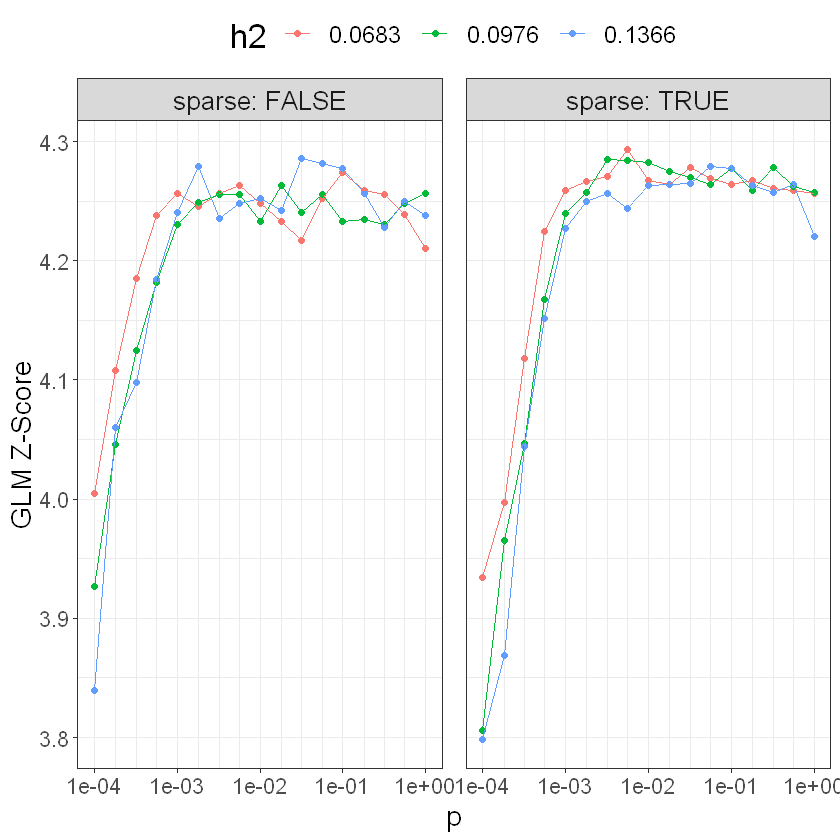

In [25]:
ggplot(params, aes(x = p, y = score, color = as.factor(h2))) +
  theme_bigstatsr() +
  geom_point() +
  geom_line() +
  scale_x_log10(breaks = 10^(-5:0), minor_breaks = params$p) +
  facet_wrap(~ sparse, labeller = label_both) +
  labs(y = "GLM Z-Score", color = "h2") +
  theme(legend.position = "top", panel.spacing = unit(1, "lines"))

In [26]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [27]:
params %>%
  mutate(sparsity = colMeans(beta_grid == 0), id = row_number()) %>%
  arrange(desc(score)) %>%
  mutate_at(c("score", "sparsity"), round, digits = 3) %>%
  slice(1:10)

p,h2,sparse,score,sparsity,id
<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<int>
0.0056,0.0683,TRUE,4.293,0.589,59
0.0320,0.1366,FALSE,4.286,0.000,45
0.0032,0.0976,TRUE,4.285,0.574,75
0.0056,0.0976,TRUE,4.284,0.572,76
0.0100,0.0976,TRUE,4.282,0.573,77
0.0560,0.1366,FALSE,4.282,0.000,46
0.0560,0.1366,TRUE,4.280,0.560,97
0.0018,0.1366,FALSE,4.279,0.000,40
0.3200,0.0976,TRUE,4.278,0.584,83


You can then choose the best model according to your preferred criterion (e.g. max AUC). Here, we use the Z-Score from the regression of the phenotype by the PRS since we have found it more robust than using the AUC. It also enables adjusting for covariates in this step (using parameter covar.train in big_univLogReg() or big_univLinReg()).

Also note that we separate both sparse and non-sparse models here (and in the paper) to show that their predictive performance are similar. In practice, if you do not really care about sparsity, you could choose the best LDpred2-grid model among all sparse and non-sparse models.

In [28]:
best_grid_nosp <- params %>%
  mutate(id = row_number()) %>%
  filter(!sparse) %>% 
  arrange(desc(score)) %>%
  slice(1) %>%
  pull(id) %>% 
  beta_grid[, .]

pred_nosp <- big_prodVec(G, best_grid_nosp, ind.row = ind.test, ind.col = ind.chr2)
AUCBoot(pred_nosp, y[ind.test])

Mean       2.5%      97.5%         Sd 
0.66829795 0.57391208 0.75985861 0.04734529

In [29]:
best_grid_sp <- params %>%
  mutate(id = row_number()) %>%
  filter(sparse) %>% 
  arrange(desc(score)) %>%
  slice(1) %>%
  pull(id) %>% 
  beta_grid[, .]

pred_sp <- big_prodVec(G, best_grid_sp, ind.row = ind.test, ind.col = ind.chr2)
AUCBoot(pred_sp, y[ind.test])

Mean       2.5%      97.5%         Sd 
0.67376777 0.57560786 0.76741120 0.04862626

## Automatic model
We recommend to run many of them in parallel with different initial values for p (e.g. length.out = 30).

In [30]:
# takes a few minutes
multi_auto <- snp_ldpred2_auto(corr, df_beta, h2_init = h2_est,
                               vec_p_init = seq_log(1e-4, 0.9, length.out = NCORES),
                               ncores = NCORES)
str(multi_auto)

List of 4
 $ :List of 8
  ..$ beta_est   : num [1:44947] -1.17e-06 -5.33e-06 -8.73e-06 -7.82e-06 -8.15e-07 ...
  ..$ postp_est  : num [1:44947] 0.126 0.126 0.126 0.126 0.126 ...
  ..$ p_est      : num 0.126
  ..$ h2_est     : num 0.00159
  ..$ path_p_est : num [1:1500] 0.000102 0.000141 0.000106 0.000194 0.000184 ...
  ..$ path_h2_est: num [1:1500] 0.0155 0.0365 0.0327 0.0643 0.0901 ...
  ..$ h2_init    : num 0.0976
  ..$ p_init     : num 1e-04
 $ :List of 8
  ..$ beta_est   : num [1:44947] -1.59e-07 -7.26e-07 -1.19e-06 -1.07e-06 -1.12e-07 ...
  ..$ postp_est  : num [1:44947] 0.0118 0.0118 0.0118 0.0118 0.0118 ...
  ..$ p_est      : num 0.0118
  ..$ h2_est     : num 0.000218
  ..$ path_p_est : num [1:1500] 0.00184 0.00187 0.00203 0.00187 0.00185 ...
  ..$ path_h2_est: num [1:1500] 0.101 0.116 0.145 0.138 0.144 ...
  ..$ h2_init    : num 0.0976
  ..$ p_init     : num 0.00208
 $ :List of 8
  ..$ beta_est   : num [1:44947] -1.27e-06 -5.80e-06 -9.50e-06 -8.51e-06 -8.85e-07 ...
  ..$ postp_

You should verify if the chains “converged”. You can look at the path of the chains, as shown below. In the paper, we propose an automatic way to filter bad chains by comparing the scale of the resulting predictions (see this [code](https://github.com/privefl/paper-ldpred2/blob/master/code/run-ldpred2-gwide.R#L108-L112), reproduced below).

This is not the case here, which is probably because the data is so small.

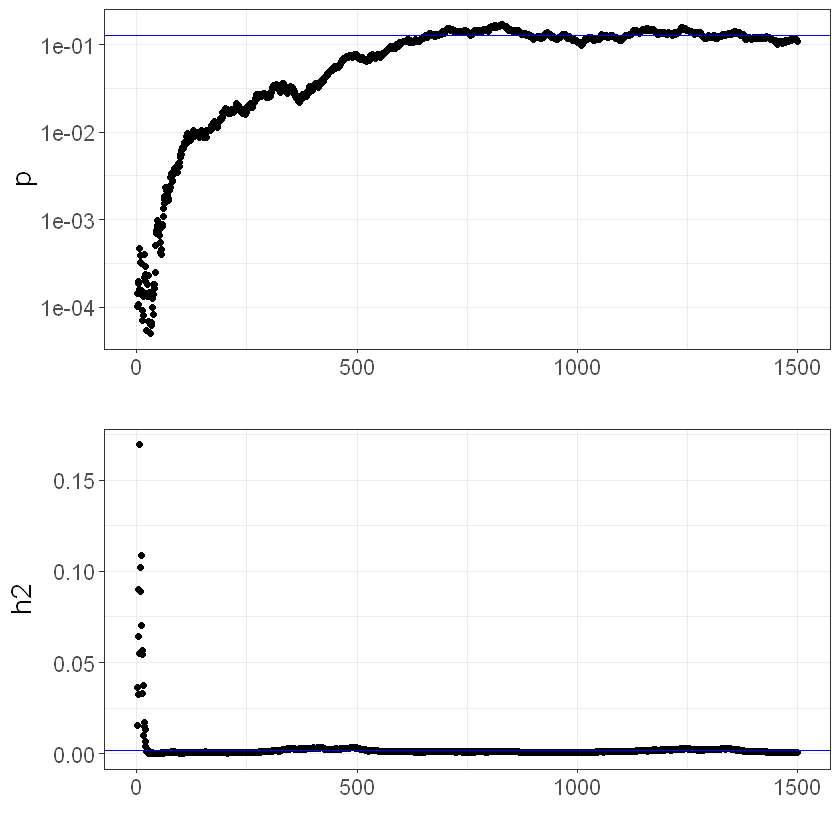

In [31]:
auto <- multi_auto[[1]]
plot_grid(
  qplot(y = auto$path_p_est) + 
    theme_bigstatsr() + 
    geom_hline(yintercept = auto$p_est, col = "blue") +
    scale_y_log10() +
    labs(y = "p"),
  qplot(y = auto$path_h2_est) + 
    theme_bigstatsr() + 
    geom_hline(yintercept = auto$h2_est, col = "blue") +
    labs(y = "h2"),
  ncol = 1, align = "hv"
)

In [32]:
beta_auto <- sapply(multi_auto, function(auto) auto$beta_est)
pred_auto <- big_prodMat(G, beta_auto, ind.row = ind.test, ind.col = ind.chr2)

In [33]:
sc <- apply(pred_auto, 2, sd)
keep <- abs(sc - median(sc)) < 3 * mad(sc)
final_beta_auto <- rowMeans(beta_auto[, keep])
final_pred_auto <- rowMeans(pred_auto[, keep])

In [34]:
AUCBoot(final_pred_auto, y[ind.test])

Mean       2.5%      97.5%         Sd 
0.66928662 0.57323081 0.75902438 0.04756111

In [35]:
# Some cleaning
rm(corr); gc(); file.remove(paste0(tmp, ".sbk"))

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2409400,128.7,4449390,237.7,4449390,237.7
Vcells,54658055,417.1,161324136,1230.9,251908186,1922.0


[1] TRUE

## Conclusion
We have seen how to run 3 versions of LDpred2 (“-inf”, “-grid” and “-auto”) for one chromosome.

Note that we now recommend to run LDpred2 genome-wide, contrary to what was shown in the first versions of this tutorial. The only difference it makes is when building the SFBM (the sparse LD matrix on disk), you need to build it so that it contains all variants genome-wide (see e.g. [this code](https://github.com/privefl/paper-ldpred2/blob/master/code/run-ldpred2-gwide.R#L39-L64)).
